# Setup

## Importing libraries

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statistics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

## Defining functions

In [2]:
def handle_outliers(data, column, operation):
    """
    Fucntion to count (c) or delete (d) outliers depending on the operation chosen/
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if operation == 'c':
      outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
      return outliers.shape[0], outliers[column]
    elif operation == 'd':
      df_clean = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
      return df_clean

# Understanding data

In [3]:
doctor_data = pd.read_csv('good_doctor_data.csv')
print(doctor_data.shape)
doctor_data.head()

(7679, 13)


,Unique_ID,# Pregnancies,Blood Chemestry~I,Blood Chemisty~II,Blood Chemisty~III,Blood Pressure,Skin Thickness,BMI,Genetic Predisposition Factor,Age,Air Qual'ty Index,$tate,Outcome
0,5642118.0,1.0,0.0,23.0,10.0,74.0,20.0,27.7,0.299,21.0,38.0,CA,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5642119.0,1.0,0.0,0.0,61.0,68.0,35.0,32.0,0.389,22.0,10.0,CA,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5642120.0,1.0,0.0,0.0,172.0,48.0,20.0,24.7,0.140,22.0,77.0,CA,0.0


Half of the records are missing values

In [4]:
doctor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7679 entries, 0 to 7678
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unique_ID                      3840 non-null   float64
 1   # Pregnancies                  3840 non-null   float64
 2   Blood Chemestry~I              3815 non-null   float64
 3   Blood Chemisty~II              3830 non-null   float64
 4   Blood Chemisty~III             3840 non-null   float64
 5   Blood Pressure                 3840 non-null   float64
 6   Skin Thickness                 3835 non-null   float64
 7   BMI                            3840 non-null   float64
 8   Genetic Predisposition Factor  3840 non-null   float64
 9   Age                            3840 non-null   float64
 10  Air Qual'ty Index              3810 non-null   float64
 11  $tate                          3840 non-null   object 
 12  Outcome                        3840 non-null   f

Cleaning data

In [5]:
doctor_data = doctor_data[~pd.isnull(doctor_data).all(axis=1)].reset_index(drop=True)
doctor_data = doctor_data.drop(columns=['Unique_ID'])
doctor_data = doctor_data.drop_duplicates()
doctor_data = doctor_data.rename(columns={"Air Qual'ty Index": "Air Quality Index", "$tate": "State", "Blood Chemisty~II":"Blood Chemistry~II", "Blood Chemisty~III":"Blood Chemistry~III"})
doctor_data['Outcome'].value_counts()

,count
Outcome,
0.0,2489
1.0,1332


Quite an imbalance present in the outcome variable. Around 35% of the records are marked as having an illness

In [6]:
print(doctor_data['State'].unique())

['CA' 'OR' 'CT' 'UT' 'WV' 'TN' 'VA' 'FL' 'KY' 'WI' 'AR' 'MA' 'PA' 'AZ'
 'IA' 'MO' 'CO' 'GA' 'SC' 'OH' 'MD' 'IL' 'OK' 'NY' 'LA' 'NC' 'MN' 'NE'
 'NJ' 'MS' 'IN' 'KS' 'DE' 'MT' 'AL' 'MI' 'NV' 'WA' 'SD' 'ME' 'ID' 'HI'
 'TX' 'NH' 'RI' 'NM' 'ND' 'VT' 'KU']


Invalid state abbreviation 'KU'

In [7]:
doctor_data[doctor_data['State'] == 'KU']

,# Pregnancies,Blood Chemestry~I,Blood Chemistry~II,Blood Chemistry~III,Blood Pressure,Skin Thickness,BMI,Genetic Predisposition Factor,Age,Air Quality Index,State,Outcome
520,10.0,101.0,0.0,60.0,86.0,37.0,45.6,1.136,38.0,78.0,KU,1.0
631,5.0,139.0,160.0,56.0,80.0,35.0,31.6,0.361,25.0,89.0,KU,1.0
1288,10.0,101.0,0.0,117.0,86.0,37.0,45.6,1.136,38.0,78.0,KU,1.0
1399,5.0,139.0,160.0,283.0,80.0,35.0,31.6,0.361,25.0,89.0,KU,1.0
2056,10.0,101.0,0.0,20.0,86.0,37.0,45.6,1.136,38.0,78.0,KU,1.0
2167,5.0,139.0,160.0,195.0,80.0,35.0,31.6,0.361,25.0,89.0,KU,1.0
2824,10.0,101.0,0.0,197.0,86.0,37.0,45.6,1.136,38.0,78.0,KU,1.0
2935,5.0,139.0,160.0,330.0,80.0,35.0,31.6,0.361,25.0,89.0,KU,1.0
3592,10.0,101.0,0.0,75.0,86.0,37.0,45.6,1.136,38.0,78.0,KU,1.0
3703,5.0,139.0,160.0,55.0,80.0,35.0,31.6,0.361,25.0,89.0,KU,1.0


In [8]:
doctor_data = doctor_data[~(doctor_data['State'] == 'KU')]

In [9]:
doctor_data.describe()

,# Pregnancies,Blood Chemestry~I,Blood Chemistry~II,Blood Chemistry~III,Blood Pressure,Skin Thickness,BMI,Genetic Predisposition Factor,Age,Air Quality Index,Outcome
count,3811.000000,3786.000000,3801.000000,3811.000000,3811.000000,3806.000000,3811.000000,3811.000000,3811.000000,3781.000000,3811.000000
mean,3.836788,120.973587,79.911865,174.061401,69.044083,20.502365,31.967777,0.471671,33.526633,49.030944,0.346891
std,3.368936,31.908718,115.479756,100.904216,19.381260,15.956177,7.881533,0.331133,13.751354,29.124216,0.476043
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000
25%,1.000000,99.000000,0.000000,86.000000,62.000000,0.000000,27.300000,0.243000,24.000000,24.000000,0.000000
50%,3.000000,117.000000,32.000000,174.000000,72.000000,23.000000,32.000000,0.374000,29.000000,49.000000,0.000000
75%,6.000000,141.000000,127.000000,259.000000,80.000000,32.000000,36.550000,0.626500,41.000000,72.000000,1.000000
max,17.000000,199.000000,846.000000,350.000000,122.000000,99.000000,67.100000,2.420000,230.000000,100.000000,1.000000


Possible outliers detected

# Handling outliers

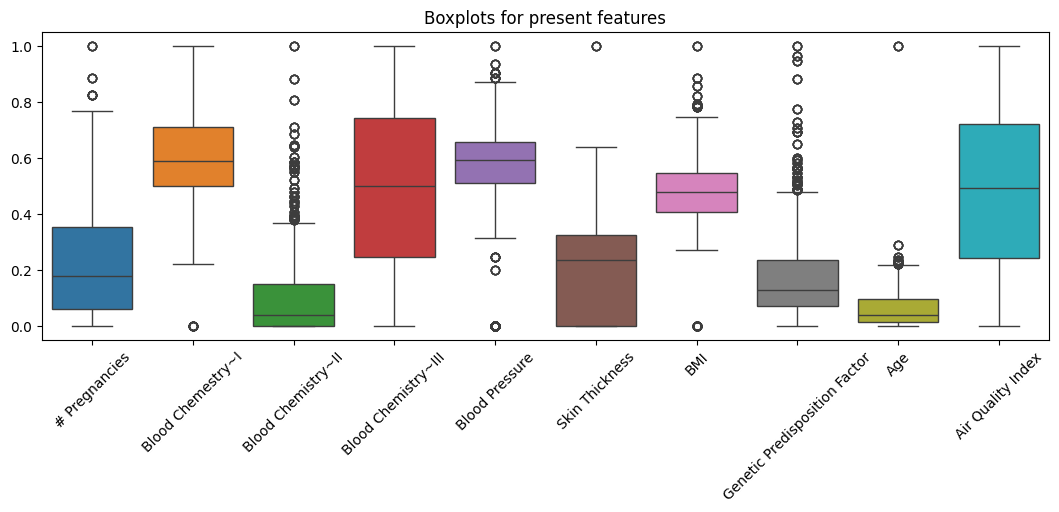

In [10]:
numeric_columns = doctor_data.select_dtypes(include='float64').columns.drop('Outcome')

#scaling for better visibility
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(doctor_data[numeric_columns])
normalized_df = pd.DataFrame(normalized_data, columns=numeric_columns)

plt.figure(figsize=(13, 4))
sns.boxplot(data=normalized_df)
plt.xticks(rotation=45)
plt.title('Boxplots for present features')

plt.show()


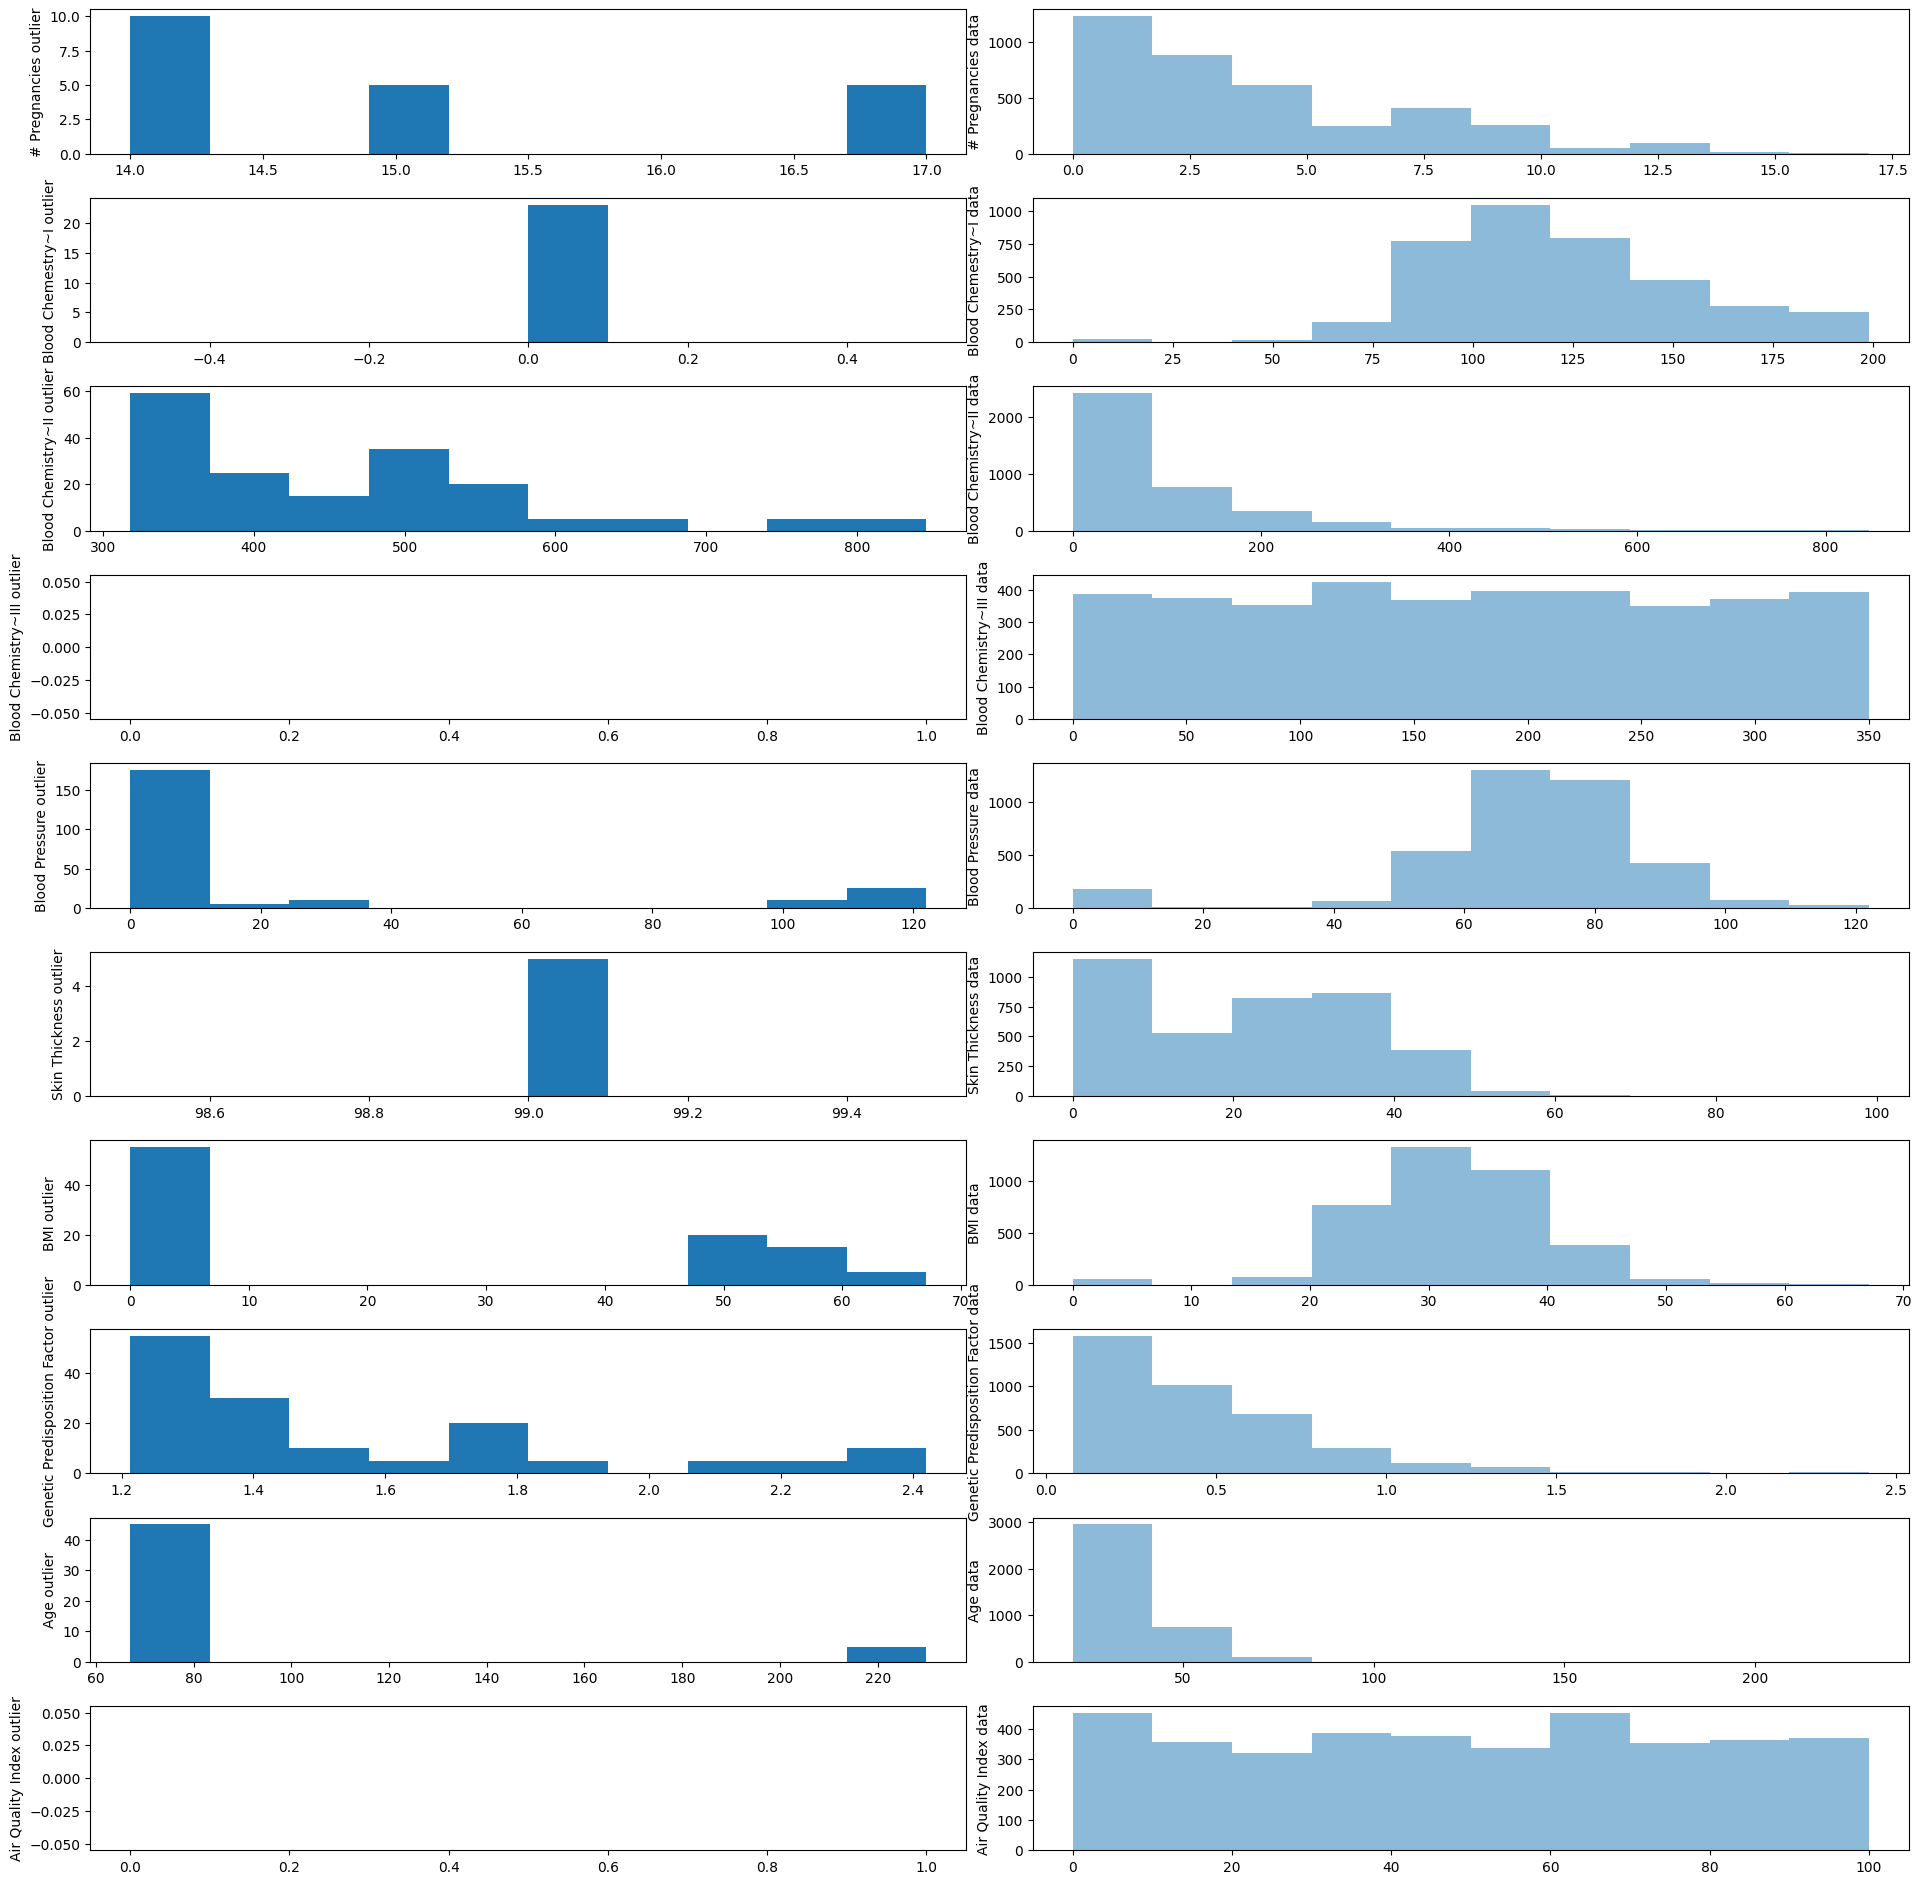

In [11]:
fig, ax = plt.subplots(10,2, figsize=(19, 19))
fig.tight_layout()

for i, col in enumerate(numeric_columns):
  ax[i,0].hist(handle_outliers(doctor_data,col,'c')[1])
  ax[i,1].hist(doctor_data[col],alpha=0.5)
  ax[i,0].set_ylabel(f'{col} outlier')
  ax[i,1].set_ylabel(f'{col} data')

  # print(col,)

plt.show()

Outliers shown seperately to be able to detect them easily

Before making the final decision of what to do with the outliers let's investigate the impact of features on the outocme.

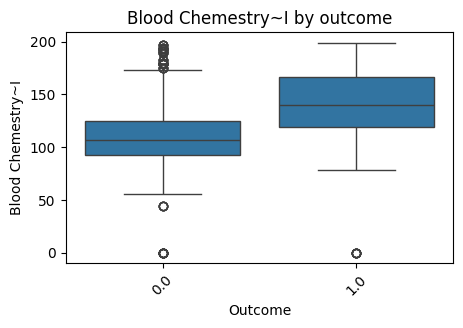

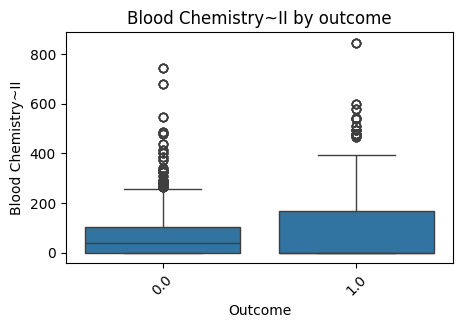

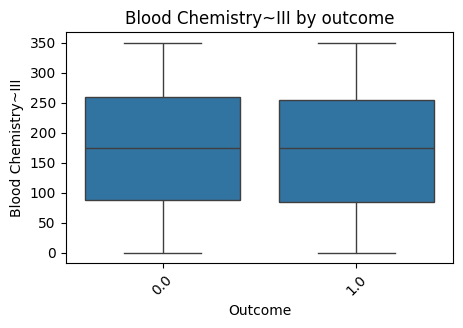

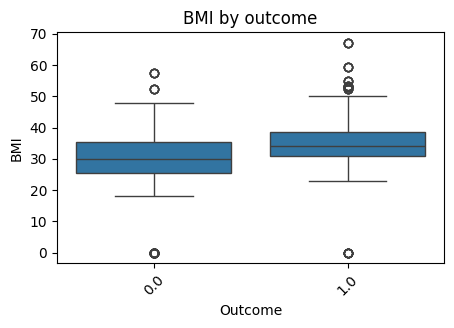

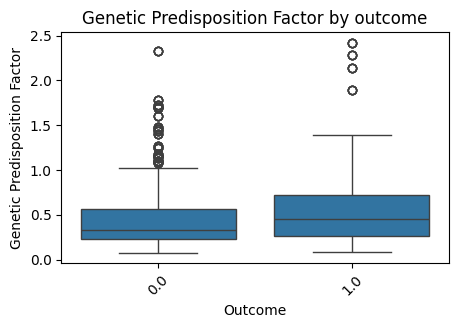

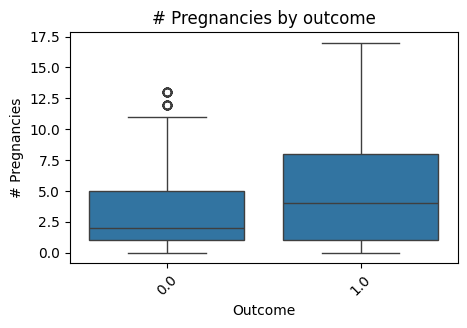

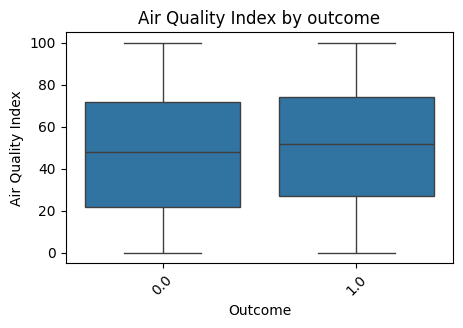

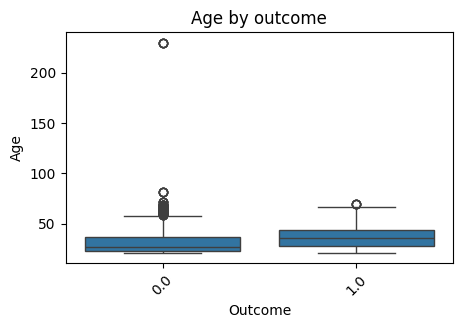

In [12]:
cols= ['Blood Chemestry~I', 'Blood Chemistry~II', 'Blood Chemistry~III', 'BMI', 'Genetic Predisposition Factor', '# Pregnancies', 'Air Quality Index', 'Age']

for col in cols:
  plt.figure(figsize=(5,3))
  sns.boxplot(y=doctor_data[col],x=doctor_data['Outcome'])
  plt.xticks(rotation=45)
  plt.title(f'{col} by outcome')

  plt.show()

The extreme values may have an impact on the outcome

In [13]:
valid_age_range = (0, 120)
valid_bmi_range = (10, 70)
valid_bp_range = (50, 200)

doctor_data = handle_outliers(doctor_data,"# Pregnancies",'d')
doctor_data = handle_outliers(doctor_data,"Skin Thickness",'d')
doctor_data = doctor_data[(doctor_data['Age'] > valid_age_range[0]) & (doctor_data['Age'] <= valid_age_range[1])]
doctor_data = doctor_data[(doctor_data['BMI'] > valid_bmi_range[0]) & (doctor_data['BMI'] <= valid_bmi_range[1])]
doctor_data = doctor_data[(doctor_data['Blood Pressure'] > valid_bp_range[0]) & (doctor_data['Blood Pressure'] <= valid_bp_range[1])]
doctor_data.head()

,# Pregnancies,Blood Chemestry~I,Blood Chemistry~II,Blood Chemistry~III,Blood Pressure,Skin Thickness,BMI,Genetic Predisposition Factor,Age,Air Quality Index,State,Outcome
0,1.0,0.0,23.0,10.0,74.0,20.0,27.7,0.299,21.0,38.0,CA,0.0
1,1.0,0.0,0.0,61.0,68.0,35.0,32.0,0.389,22.0,10.0,CA,0.0
3,5.0,44.0,0.0,207.0,62.0,0.0,25.0,0.587,36.0,40.0,OR,0.0
4,2.0,56.0,45.0,150.0,56.0,28.0,24.2,0.332,22.0,70.0,CT,0.0
5,9.0,57.0,0.0,334.0,80.0,37.0,32.8,0.096,41.0,64.0,UT,0.0


# Handling null values

In [14]:
doctor_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3436 entries, 0 to 3839
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   # Pregnancies                  3436 non-null   float64
 1   Blood Chemestry~I              3416 non-null   float64
 2   Blood Chemistry~II             3426 non-null   float64
 3   Blood Chemistry~III            3436 non-null   float64
 4   Blood Pressure                 3436 non-null   float64
 5   Skin Thickness                 3436 non-null   float64
 6   BMI                            3436 non-null   float64
 7   Genetic Predisposition Factor  3436 non-null   float64
 8   Age                            3436 non-null   float64
 9   Air Quality Index              3411 non-null   float64
 10  State                          3436 non-null   object 
 11  Outcome                        3436 non-null   float64
dtypes: float64(11), object(1)
memory usage: 349.0+ KB


Decisions of iputing null values were made based on distribution of data

In [15]:
doctor_data['Air Quality Index'] = doctor_data.groupby('State')['Air Quality Index'].transform(lambda x: x.fillna(x.mean()))
doctor_data['Blood Chemestry~I'] = doctor_data.groupby('Outcome')['Blood Chemestry~I'].transform(lambda x: x.fillna(x.mean()))
doctor_data['Blood Chemistry~II'] = doctor_data.groupby('Outcome')['Blood Chemistry~II'].transform(lambda x: x.fillna(statistics.mode(x)))

In [16]:
doctor_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3436 entries, 0 to 3839
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   # Pregnancies                  3436 non-null   float64
 1   Blood Chemestry~I              3436 non-null   float64
 2   Blood Chemistry~II             3436 non-null   float64
 3   Blood Chemistry~III            3436 non-null   float64
 4   Blood Pressure                 3436 non-null   float64
 5   Skin Thickness                 3436 non-null   float64
 6   BMI                            3436 non-null   float64
 7   Genetic Predisposition Factor  3436 non-null   float64
 8   Age                            3436 non-null   float64
 9   Air Quality Index              3436 non-null   float64
 10  State                          3436 non-null   object 
 11  Outcome                        3436 non-null   float64
dtypes: float64(11), object(1)
memory usage: 349.0+ KB


# Exploratory data analysis

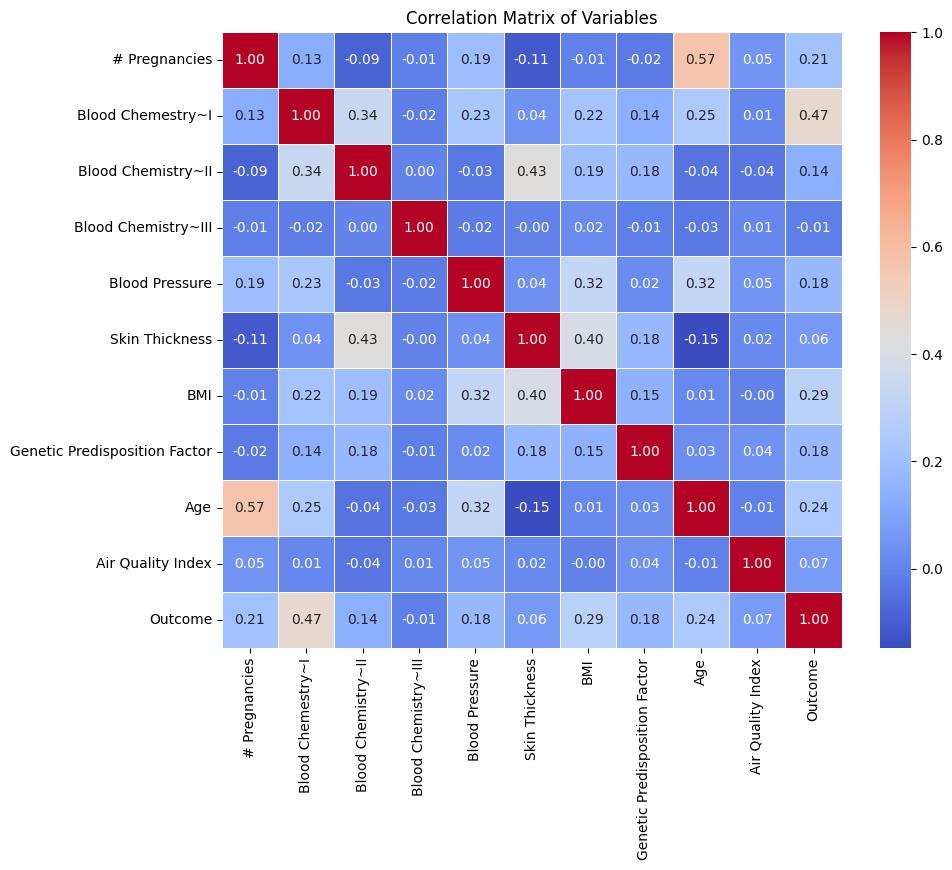

In [17]:
correlation_matrix = doctor_data.drop(['State'],axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Variables')
plt.show()

We can notice a few significant observations:


*   Outcome is correlated the most with blood chemistry~I, BMI and number of Pregnancies
*   number of Pregnancies is strongly correlated with age (could delete the feature)



In [18]:
doctor_data.drop(columns=['State']).groupby('Outcome').agg(['mean','median','std','max']).transpose()

Outcome                                      0.0         1.0
# Pregnancies                 mean      3.379859    4.816553
                              median    2.000000    4.000000
                              std       3.063139    3.491304
                              max      13.000000   13.000000
Blood Chemestry~I             mean    110.578924  141.944302
                              median  108.000000  142.500000
                              std      25.833146   31.690909
                              max     197.000000  199.000000
Blood Chemistry~II            mean     71.254417  105.174915
                              median   44.000000    0.000000
                              std     100.127522  143.201437
                              max     744.000000  846.000000
Blood Chemistry~III           mean    174.013693  171.419795
                              median  173.000000  172.000000
                              std     101.053476  100.105356
                              max     350.000000  350.000000
Blood Pressure                mean     72.049912   76.229522
                              median   72.000000   76.000000
                              std      11.040786   11.202936
                              max     122.000000  114.000000
Skin Thickness                mean     20.481007   22.587884
                              median   22.000000   27.000000
                              std      14.866339   16.843783
                              max      60.000000   63.000000
BMI                           mean     31.089311   35.206058
                              median   30.700000   34.200000
                              std       6.547590    6.536808
                              max      57.300000   67.100000
Genetic Predisposition Factor mean      0.428883    0.550035
                              median    0.336000    0.445000
                              std       0.297919    0.363180
                              max       2.329000    2.420000
Age                           mean     31.474823   37.492321
                              median   27.000000   36.000000
                              std      11.609696   11.083679
                              max      81.000000   70.000000
Air Quality Index             mean     47.587140   51.940108
                              median   48.000000   53.000000
                              std      29.272304   27.759782
                              max     100.000000  100.000000

# Model

In [19]:
doctor_data['Outcome'].value_counts()[1]/(doctor_data['Outcome'].value_counts()[0]+doctor_data['Outcome'].value_counts()[1])


0.3410942956926659

In [20]:
X = doctor_data.drop(columns=['Outcome', 'State'])
y = doctor_data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=82)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic regression



Using grid search to tune best hyperparameters. Cross validation shows that the model can generalize

In [22]:
lr = LogisticRegression(random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],        # Regularization type
    'solver': ['liblinear', 'saga'] # Solvers that support l1 penalty
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid,
                           scoring='recall', cv=5, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model using cross-validation accuracy scores
accuracy_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print('Accuracy scores with cross-validation:', accuracy_scores)

Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy scores with cross-validation: [0.78586279 0.78378378 0.78586279 0.75051975 0.79417879]


## Random Forest



In [24]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [5, 10, 15],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]          # Minimum samples required to be at a leaf node
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='recall', cv=5, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model using cross-validation accuracy scores
accuracy_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print('Accuracy scores with cross-validation:', accuracy_scores)


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy scores with cross-validation: [0.96257796 0.97920998 0.97920998 0.98128898 0.99168399]


## Decision tree

In [25]:
dt = DecisionTreeClassifier(class_weight='balanced',random_state=42)

param_grid = {
    'max_depth': [5,6,7,8,9,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           scoring='recall', cv=5, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

best_model = grid_search.best_estimator_
print('Accuracy scores with cross validation:',cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy'))


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy scores with cross validation: [0.95634096 0.91268191 0.94802495 0.93970894 0.92931393]


The DecisionTreeClassifier was chosen thanks to its high interpretability and low complexity in order to help the doctor understand what decisions were made to classify each record

In [26]:
X = doctor_data.drop(columns=['Outcome', 'State','Blood Chemistry~III'])
y = doctor_data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=82)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dt = DecisionTreeClassifier(class_weight='balanced',random_state=42)

In [27]:
param_grid = {
    'max_depth': [5,6,7,8,9,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           scoring='recall', cv=5, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

best_model = grid_search.best_estimator_
print('Accuracy scores with cross validation:',cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy'))


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy scores with cross validation: [0.96465696 0.91476091 0.95218295 0.95841996 0.95218295]


In [28]:
y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

Accuracy: 0.9399
Precision: 0.8753
Recall: 0.9601
F1-Score: 0.9158
ROC-AUC: 0.9448


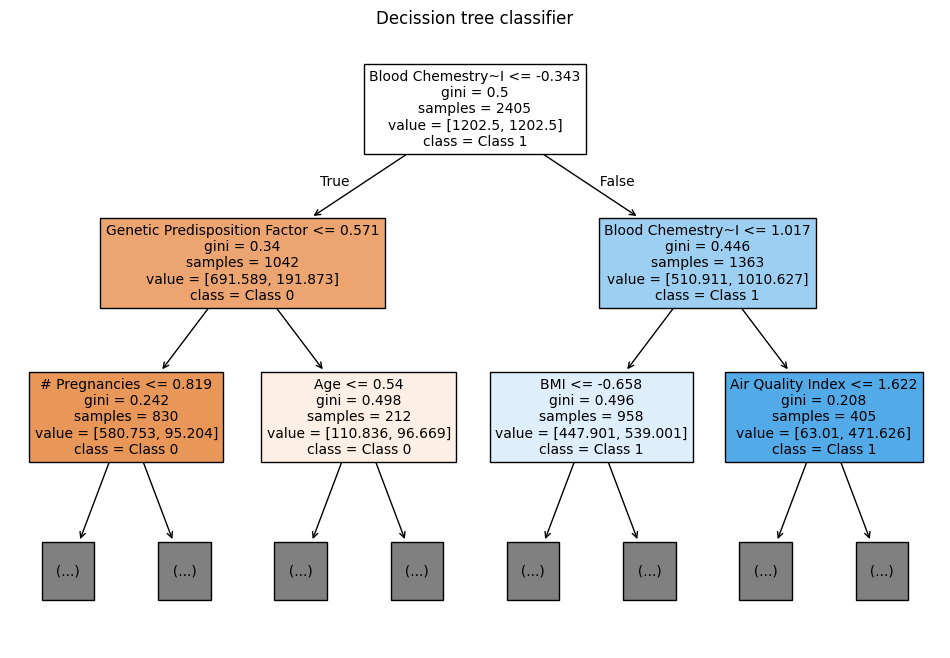

In [ ]:
plt.figure(figsize=(12,8))
plot_tree(best_model, max_depth=2, feature_names=X.columns, class_names=['Class 0', 'Class 1'], filled=True, fontsize=10)
plt.title('Decission tree classifier')
plt.show()

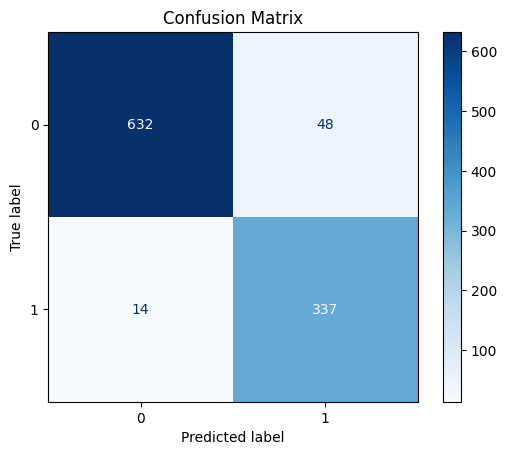

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

<Axes: title={'center': 'Most important features'}>

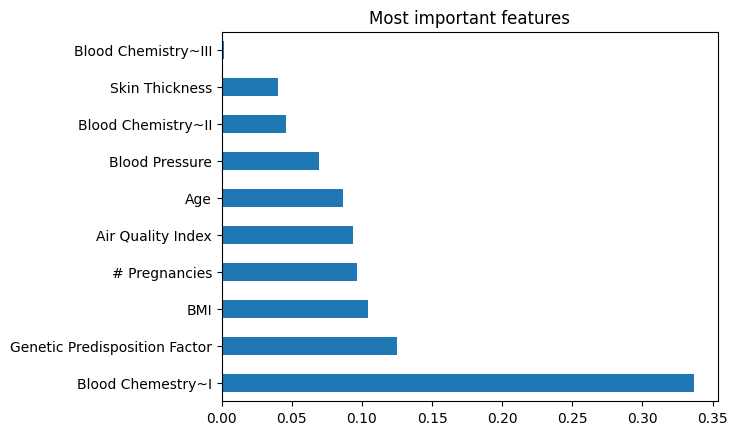

In [ ]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='barh', title='Most important features')


We can see that the most important features in deciding if a person is ill or not are: Blood Chemestry~I, Genetic Predisposition Factor, BMI, # Pregnancies and Air Quality Index